In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("sentimentdataset.csv")

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [4]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,float64,0,0.000000
9,Likes,float64,0,0.000000


In [5]:
df.duplicated().sum()

0

In [6]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [7]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


In [8]:
#Drop Columns
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])


In [9]:
df['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [10]:
df['Platform'] = df['Platform'].str.strip()

In [11]:
df['Country'].value_counts()

Country
USA               59
USA               55
UK                49
Canada            44
Australia         41
                  ..
Netherlands        1
USA                1
Germany            1
France             1
USA                1
Name: count, Length: 115, dtype: int64

In [12]:
df['Country'] = df['Country'].str.strip()

In [13]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [14]:
month_mapping = {
    1: 'Januari',
    2: 'Februari',
    3: 'Maret',
    4: 'April',
    5: 'Mei',
    6: 'Juni',
    7: 'Juli',
    8: 'Agustus',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Desember'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

In [15]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

    df["Clean_Text"] = df["Text"].apply(clean)

In [16]:
specified_columns = ['Platform','Country', 'Year','Month','Day_of_Week']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')  

Total unique values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total unique values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Sweden: 2
Colombia: 1
Scotland: 1
Kenya: 1
Jamaica: 1
Ireland: 1
China: 1
Norway: 1
Cambodia: 1
Maldives: 1
Peru: 1
Jordan: 1
Thailand: 1


Total unique values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2012: 4
2013: 4
2014: 4
2010: 3


Total unique values for Month: 12
Februari: 85
Januari: 82
Agustus: 78
September: 77
Juni: 71
Juli: 62
April: 51
November: 49
Oktober: 48
Mei: 46
Maret: 44
Desember: 39


Total unique values for Day_of_Week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




In [17]:
df1 = df.copy()

In [18]:
analyzer = SentimentIntensityAnalyzer()

# Adjust column name as needed
df1['Vader_Score'] = df1['Text'].apply(lambda text: analyzer.polarity_scores(str(text))['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Text', 'Vader_Score', 'Sentiment']].head())


                                                Text  Vader_Score Sentiment
0   Enjoying a beautiful day at the park!        ...       0.8221  positive
1   Traffic was terrible this morning.           ...      -0.4767  negative
2   Just finished an amazing workout! 💪          ...       0.6239  positive
3   Excited about the upcoming weekend getaway!  ...       0.4003  positive
4   Trying out a new recipe for dinner tonight.  ...       0.0000   neutral


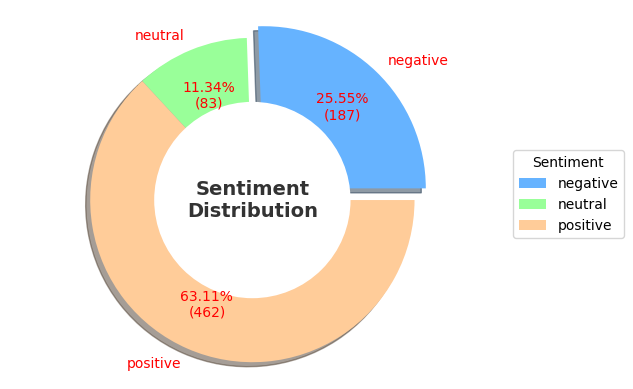

In [19]:
colors = ['#66b3ff', '#99ff99', '#ffcc99']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

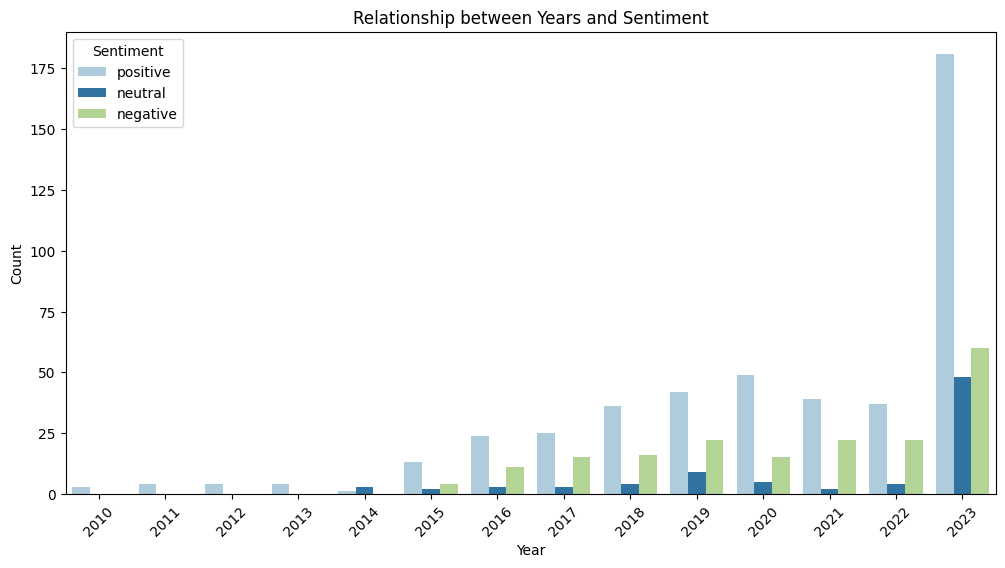

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

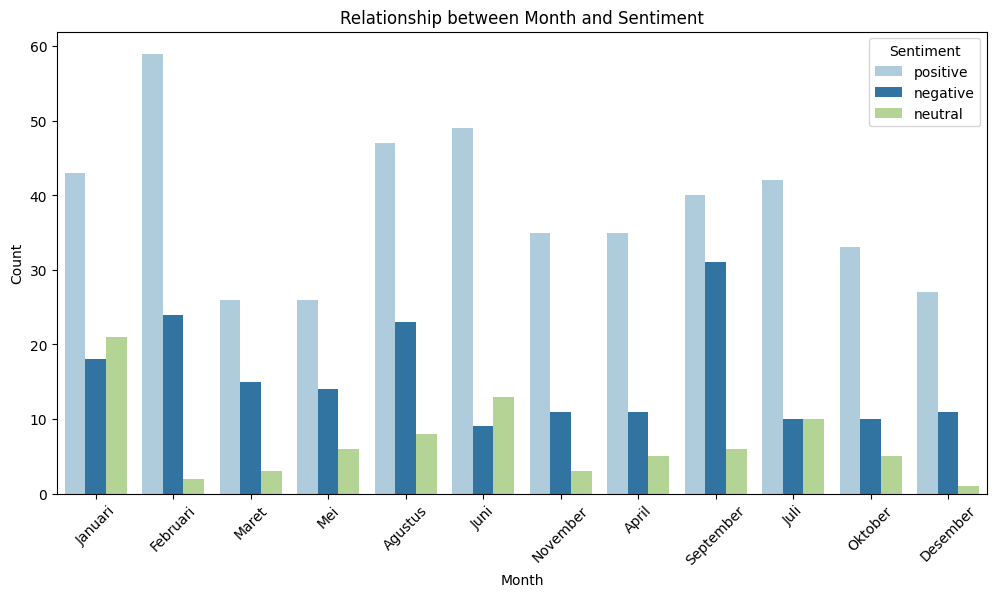

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Month and Sentiment')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

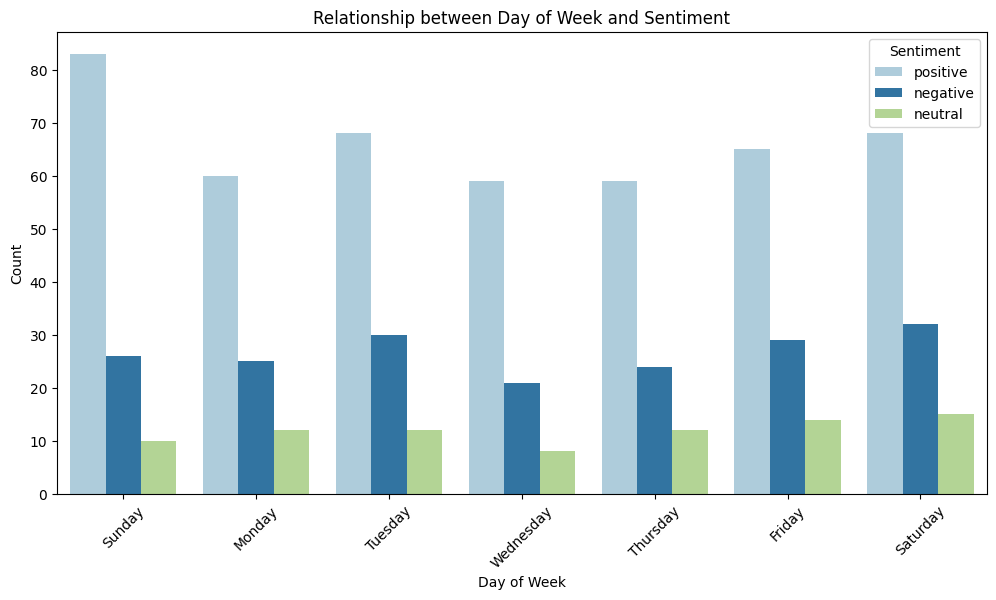

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Day_of_Week', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Day of Week and Sentiment')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


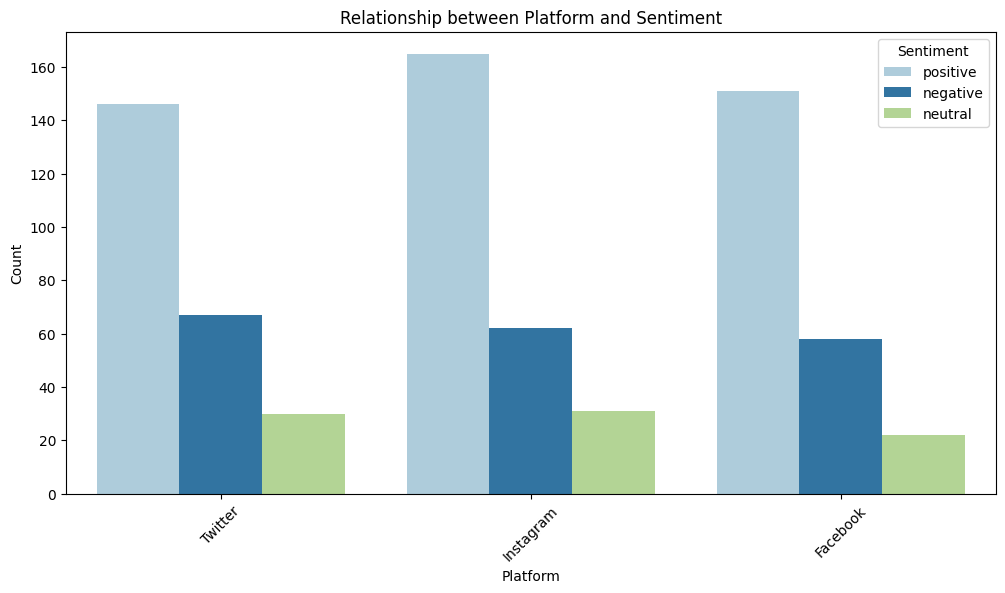

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

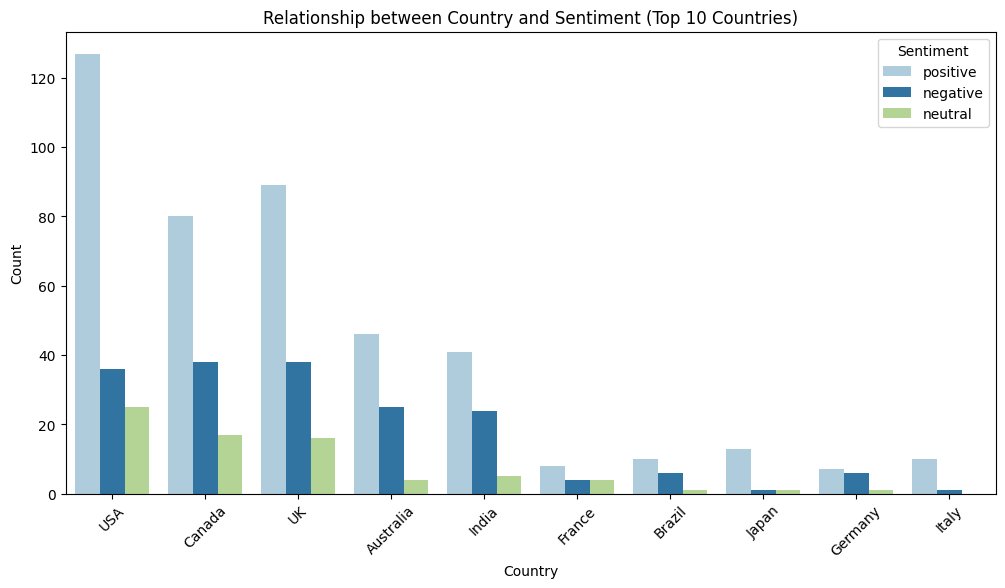

In [24]:
plt.figure(figsize=(12, 6))

top_10_countries = df1['Country'].value_counts().head(10).index

df_top_10_countries = df1[df1['Country'].isin(top_10_countries)]

sns.countplot(x='Country', hue='Sentiment', data=df_top_10_countries, palette='Paired')
plt.title('Relationship between Country and Sentiment (Top 10 Countries)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [25]:
df1['temp_list'] = df1['Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')


,Common_words,count
0,the,808
1,of,623
2,a,621
3,in,259
4,to,133
5,and,111
6,with,107
7,for,99
8,on,91
9,by,69


In [73]:
df1['temp_list'] = df1['Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()

In [28]:
Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

In [29]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,the,516
1,a,414
2,of,406
3,in,165
4,and,85
5,with,77
6,to,77
7,for,71
8,on,61
9,by,37


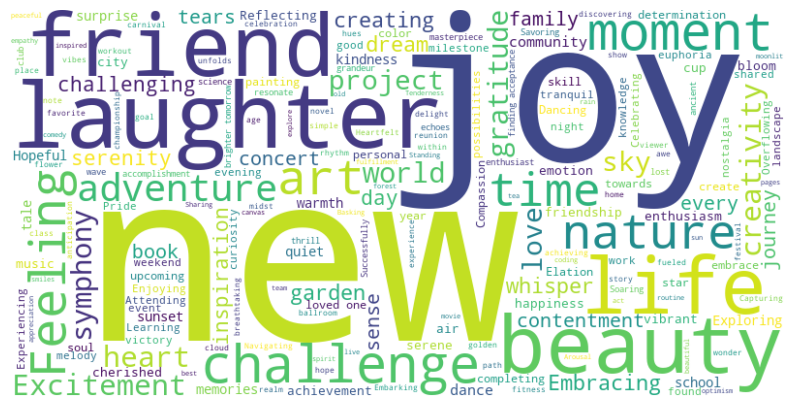

In [30]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,76
1,a,70
2,of,41
3,to,21
4,in,17
5,and,16
6,new,14
7,on,13
8,for,12
9,by,10


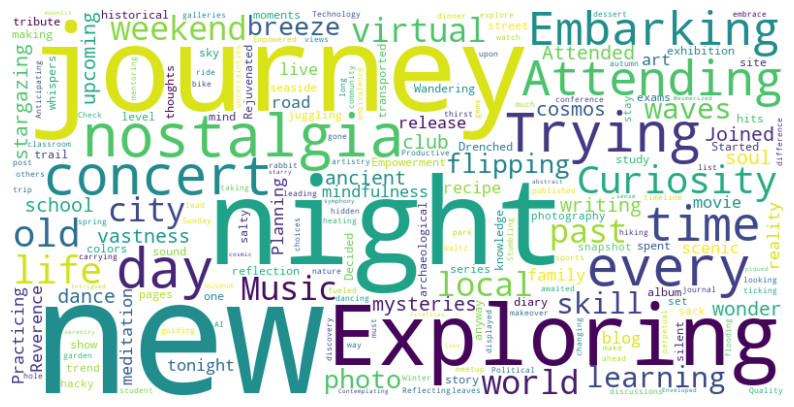

In [32]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'neutral']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')

,Common_words,count
0,the,216
1,of,176
2,a,137
3,in,77
4,to,35
5,with,23
6,by,22
7,my,17
8,on,17
9,for,16


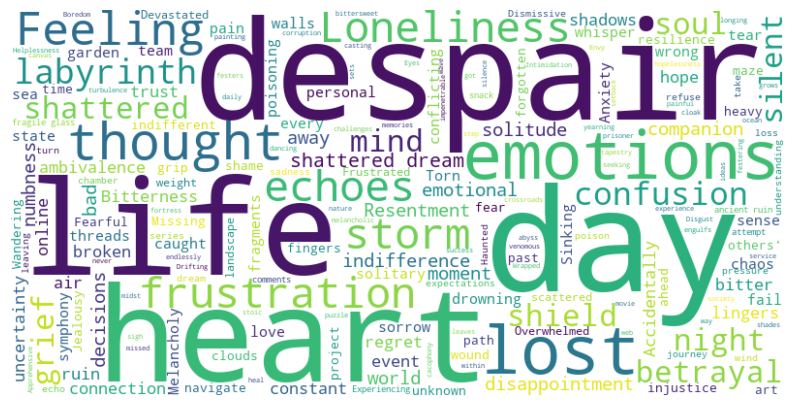

In [34]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
df2 = df1.copy()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [38]:
X = df2['Text'].values
y = df2['Sentiment'].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [41]:
pac_classifier = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac_classifier.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(max_iter=50, random_state=42)

In [42]:
y_pred = pac_classifier.predict(X_test_tfidf)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [43]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

Test Set Results:
Accuracy: 0.7959183673469388
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.79      0.82        39
     neutral       0.36      0.29      0.32        14
    positive       0.83      0.87      0.85        94

    accuracy                           0.80       147
   macro avg       0.68      0.65      0.66       147
weighted avg       0.79      0.80      0.79       147



In [44]:
logistic_classifier = LogisticRegression(max_iter=50, random_state=42)
logistic_classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=50, random_state=42)

In [45]:
y_pred_logistic = logistic_classifier.predict(X_test_tfidf)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_rep_logistic = classification_report(y_test, y_pred_logistic)

In [46]:
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logistic}")
print("Classification Report:\n", classification_rep_logistic)

Logistic Regression Results:
Accuracy: 0.7414965986394558
Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.46      0.59        39
     neutral       0.00      0.00      0.00        14
    positive       0.73      0.97      0.83        94

    accuracy                           0.74       147
   macro avg       0.52      0.48      0.47       147
weighted avg       0.68      0.74      0.69       147



In [47]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [48]:
y_pred_rf = random_forest_classifier.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

In [49]:
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:\n", classification_rep_rf)


Random Forest Results:
Accuracy: 0.7755102040816326
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.51      0.66        39
     neutral       0.67      0.14      0.24        14
    positive       0.75      0.98      0.85        94

    accuracy                           0.78       147
   macro avg       0.78      0.54      0.58       147
weighted avg       0.79      0.78      0.74       147



In [50]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [51]:
y_pred_svm = svm_classifier.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

In [52]:
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:\n", classification_rep_svm)

Support Vector Machine Results:
Accuracy: 0.7210884353741497
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.31      0.47        39
     neutral       0.00      0.00      0.00        14
    positive       0.70      1.00      0.82        94

    accuracy                           0.72       147
   macro avg       0.57      0.44      0.43       147
weighted avg       0.71      0.72      0.65       147



In [53]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [54]:
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)

In [55]:
print("\nMultinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:\n", classification_rep_nb)


Multinomial Naive Bayes Results:
Accuracy: 0.7074829931972789
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.26      0.40        39
     neutral       0.00      0.00      0.00        14
    positive       0.69      1.00      0.82        94

    accuracy                           0.71       147
   macro avg       0.53      0.42      0.41       147
weighted avg       0.68      0.71      0.63       147



In [56]:
param_dist = {
    'C': [0.1, 0.5, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

In [57]:
pac_classifier = PassiveAggressiveClassifier(random_state=42)

randomized_search = RandomizedSearchCV(pac_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
randomized_search.fit(X_train_tfidf, y_train)

-- Epoch 1
Norm: 9.50, NNZs: 1860, Bias: -0.256941, T: 468, Avg. loss: 0.580792
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 14.45, NNZs: 1905, Bias: -0.192699, T: 936, Avg. loss: 0.261810
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 16.68, NNZs: 1919, Bias: -0.186338, T: 1404, Avg. loss: 0.106961
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 17.51, NNZs: 1927, Bias: -0.186812, T: 1872, Avg. loss: 0.037911
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 17.84, NNZs: 1929, Bias: -0.186643, T: 2340, Avg. loss: 0.014614
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 18.00, NNZs: 1929, Bias: -0.187333, T: 2808, Avg. loss: 0.006330
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 18.07, NNZs: 1929, Bias: -0.187588, T: 3276, Avg. loss: 0.002615
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 18.09, NNZs: 1929, Bias: -0.188439, T: 3744, Avg. loss: 0.000753
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 18.09, NNZs: 1929, Bias: -0.188845, T: 4212, Avg. 

RandomizedSearchCV(cv=5, estimator=PassiveAggressiveClassifier(random_state=42),
                   param_distributions={'C': [0.1, 0.5, 1.0],
                                        'fit_intercept': [True, False],
                                        'shuffle': [True, False],
                                        'verbose': [0, 1]},
                   random_state=42, scoring='accuracy')

In [59]:
best_params_randomized = randomized_search.best_params_
best_params_randomized

{'verbose': 0, 'shuffle': True, 'fit_intercept': True, 'C': 0.1}

In [60]:
best_pac_classifier_randomized = PassiveAggressiveClassifier(random_state=42, **best_params_randomized)
best_pac_classifier_randomized.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(C=0.1, random_state=42)

In [61]:
y_pred_best_pac_randomized = best_pac_classifier_randomized.predict(X_test_tfidf)

In [62]:
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_rep_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)

In [63]:
print("Best PassiveAggressiveClassifier Model (RandomizedSearchCV):")
print(f"Best Hyperparameters: {best_params_randomized}")
print(f"Accuracy: {accuracy_best_pac_randomized}")
print("Classification Report:\n", classification_rep_best_pac_randomized)

Best PassiveAggressiveClassifier Model (RandomizedSearchCV):
Best Hyperparameters: {'verbose': 0, 'shuffle': True, 'fit_intercept': True, 'C': 0.1}
Accuracy: 0.7959183673469388
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.79      0.82        39
     neutral       0.36      0.29      0.32        14
    positive       0.83      0.87      0.85        94

    accuracy                           0.80       147
   macro avg       0.68      0.65      0.66       147
weighted avg       0.79      0.80      0.79       147



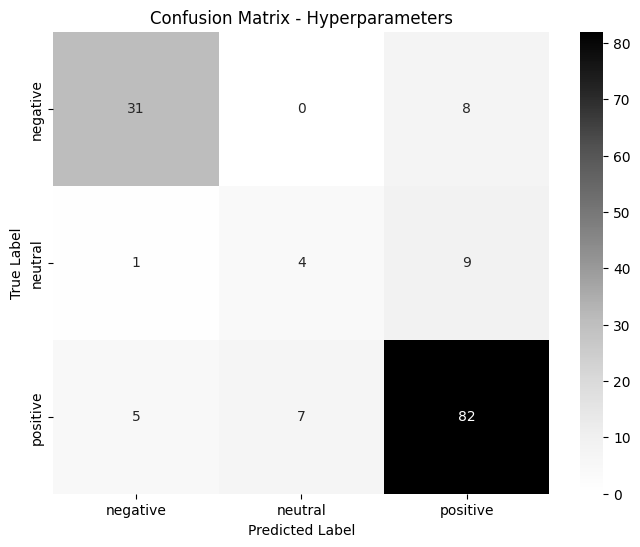

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greys', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

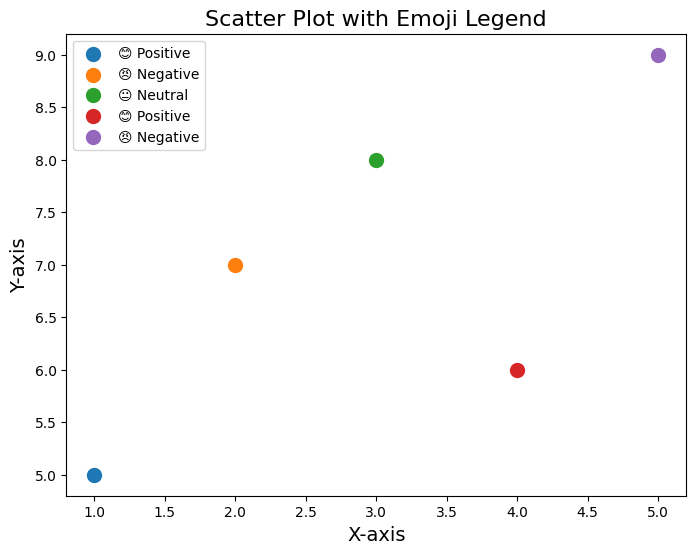

In [70]:
import matplotlib.pyplot as plt

# Sample Data
x = [1, 2, 3, 4, 5]
y = [5, 7, 8, 6, 9]
categories = ['😊 Positive', '😠 Negative', '😐 Neutral', '😊 Positive', '😠 Negative']

# Scatter Plot
plt.figure(figsize=(8, 6))
for i, sentiment in enumerate(categories):
    plt.scatter(x[i], y[i], label=sentiment, s=100)

plt.title("Scatter Plot with Emoji Legend", fontsize=16)
plt.xlabel("X-axis", fontsize=14)
plt.ylabel("Y-axis", fontsize=14)
plt.legend(loc='best')
plt.show()
